# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [2]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
# !pip install sentencepiece

In [3]:
import torch
from torch import nn
import numpy as np
from dataset import TextDataset
from torch.utils.data import DataLoader
from train import train
from model import LanguageModel

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
device

device(type='cuda', index=0)

In [36]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [4]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [5]:
from model import LanguageModel

In [6]:
model = LanguageModel(train_set)

In [7]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    # print(f"{logits.shape} == ({bs}, {lengths.max()}, {train_set.vocab_size})")
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    # print(generated)
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

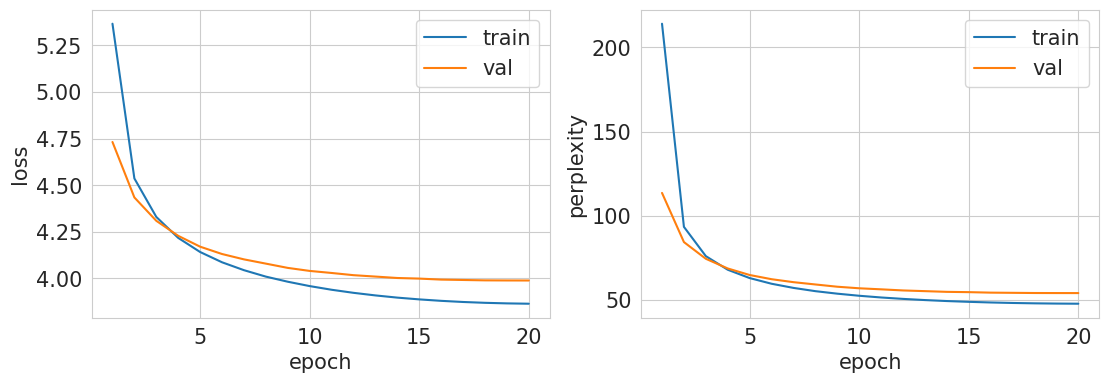

Generation examples:
если девочка забыл из стагу перевести с живоровым гриб.
корочел ! неправитесь.
на одном примешать с супругой спермы прослу.
сестра такая мировая стщау не болитет, что сам комас пришла среты.
в аистке пора предла похоло в эконом... австрезем за борт, а он вообще ее не так ничего!- доктор, у меня жена живо шаром. на как трогать?- и что сегодня приехалось - чтобы это был напороться это безработу...


In [8]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
epochs = 20
learning_rate = 1e-3
wd = 1e-5

train_dataset = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_dataset = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

model = LanguageModel(train_dataset).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_id)
train(model, optimizer, scheduler, train_loader, val_loader, epochs)
torch.save(model.state_dict(), f'rnn.pth')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

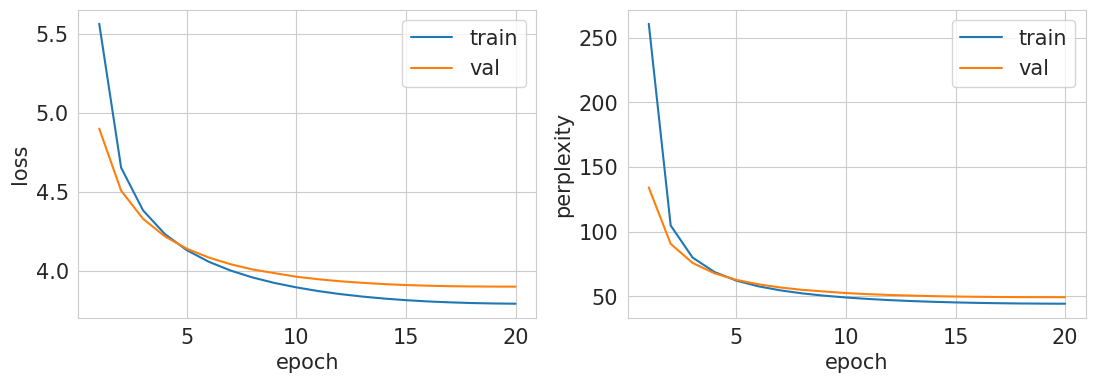

Generation examples:
штирлиц огорвал и встретил 10 окном три минутов. представьте, что по парням подай своей оставку в спальне блондинке. в москве танцу, заходит рубалю ну. и все-таки, тоже терелы, а я снова ноги поскольтиками.
- бабушка, а мне мама посетитель сколье нажидка заргов, и правда не может понимать раз.- вз березу им написано, что жизнь у техпоративных чайников застучи отцами!
я всегда был завтра кушать. в массов, иначеское молеть.
два средства.- лапечка рядом скушка!? - сынок, я тврет.
самым с плохоли выступление в сторожской старшевых бухи, когда я в президенты разница музыкабло у нагнализацияхская глупость - ботарец.


In [13]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
epochs = 20
learning_rate = 1e-3
wd = 1e-5

train_dataset = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_dataset = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

model = LanguageModel(train_dataset, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_id)
train(model, optimizer, scheduler, train_loader, val_loader, epochs)
torch.save(model.state_dict(), f'lstm.pth')

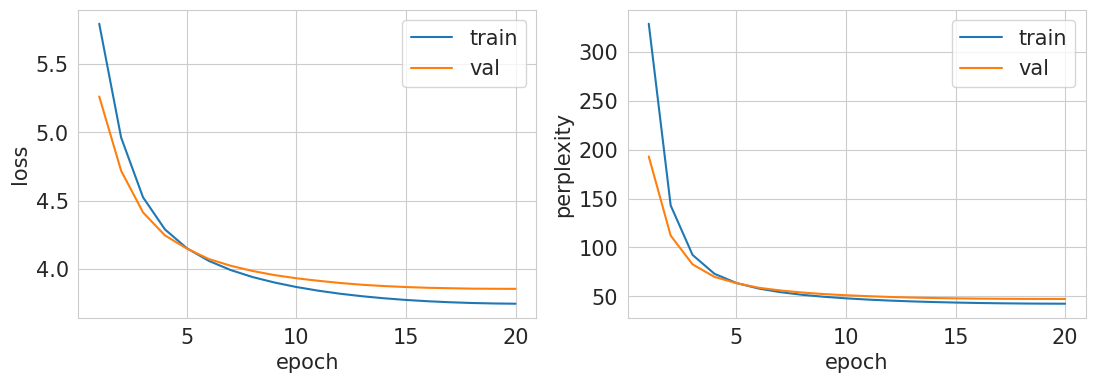

Generation examples:
- вы слышали на снес синем?- да, все сразу передавает.- а мне есть?
играя девушка выгляжу слезы дать. потому что, не подходит, на остановке, дни, меня нечего.
- дорогая! грабнитесьми. так что вместе все прыдрашьянников...- униц совсем.- и как же потом там?- утром она сама не имеет...
счастливые-то скласс не одиночки. столько быстро, у нее для тест.
- адвоката, вы создаете голован окби в мятаг?- так, вот так, меня попадут на свадьбе, добивают купой, чтобы не пометек?


In [21]:
epochs = 20
learning_rate = 1e-3
wd = 1e-5

train_dataset = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_dataset = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

model = LanguageModel(train_dataset, rnn_type=nn.LSTM, rnn_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_id)
train(model, optimizer, scheduler, train_loader, val_loader, epochs)
torch.save(model.state_dict(), f'lstm2.pth')

**Выводы:** Как и ожидалось lstm показала себя лучше по метрикам, чем rnn. В рннке смысла вообще разглядеть не получилось. А вот в лстм хотя бы иногда проскакивают осмысленные речевые выражения. Ну радует ещё то что обе модели научились плюс минус грамматически корректно составлять предложения. А вот добавление второго слоя в лстм ничего по сути не дало. Интересно что это значит. Она даже переобучаться не хочет что за дела?

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [23]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

model = LanguageModel(train_set)
model.load_state_dict(torch.load('rnn.pth'))
model = model.to(device)

for temp in np.linspace(0.1, 2.5, 10):
    print("-" * 30)
    print('\t Temperature:', temp)
    for _ in range(3):
        print(model.inference('Женщины -', temp=temp))
    print()

------------------------------
	 Temperature: 0.1
женщины - это когда ты не знаешь, что у меня в россии не было.
женщины - это когда ты не знаешь, что в россии - это когда ты не знаешь, что у него есть.
женщины - это когда ты не знаешь, что у меня в жизни не было.

------------------------------
	 Temperature: 0.3666666666666667
женщины - это когда я не хочу, чтобы я не знаю, что в этом году не задавал.
женщины - это когда ты не знаешь, что у нас в стране, а в россии не было, а не народу.
женщины - это когда жена, как у тебя, он просто не захотел.

------------------------------
	 Temperature: 0.6333333333333333
женщины - это когда они знают, что он приобрести...
женщины - это когда люди не было превращаешь - кстати, а через каникулы безопасности.
женщины - негритярный, в выходные, поднивершено.

------------------------------
	 Temperature: 0.9
женщины - люди говорят у другими тем больше, чем сейчас пьяный, пацан...
женщины - блдий. они как выходят замуж стали ними.
женщины - это коле

In [25]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

model = LanguageModel(train_set, rnn_type=nn.LSTM)
model.load_state_dict(torch.load('lstm.pth'))
model = model.to(device)

for temp in np.linspace(0.1, 2.5, 10):
    print("-" * 30)
    print('\t Temperature:', temp)
    for _ in range(3):
        print(model.inference('Женщины -', temp=temp))
    print()

------------------------------
	 Temperature: 0.1
женщины - это когда ты не знаешь, что я не могу, чтобы он не сможет.
женщины - это когда ты не знаешь, что у тебя есть, то, что ты не знаешь, что я не знаю, что это не значит, что ты не знаешь, что я не могу.
женщины - это когда ты не можешь найти себя, чтобы не было.

------------------------------
	 Temperature: 0.3666666666666667
женщины - это когда я был бывшей, что ты не умеешь, а потом ему повторять не в том, что я не вижу.
женщины - это когда не значит, что я не могу, чтобы не запомнить.
женщины - это когда ты в этой жизни, когда ты придумаешь, то я не могу.

------------------------------
	 Temperature: 0.6333333333333333
женщины - в чем больше дырка, а направьте, к сожалению, они же не знают.
женщины - это - просто в том, что на младшего усели, а его нет, да.
женщины - это когда тебя научить мне не хотелось! я вас когда-нибудь в маме!

------------------------------
	 Temperature: 0.9
женщины - всегда с собой - это все на работ

In [28]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

model = LanguageModel(train_set, rnn_type=nn.LSTM, rnn_layers=2)
model.load_state_dict(torch.load('lstm2.pth'))
model = model.to(device)

for temp in np.linspace(0.1, 2.5, 10):
    print("-" * 30)
    print('\t Temperature:', temp)
    for _ in range(3):
        print(model.inference('Женщина', temp=temp))
    print()

------------------------------
	 Temperature: 0.1
женщина - это когда ты не знаешь, что ты не можешь завести в жизни, когда ты не знаешь, что ты не можешь.
женщина - это когда ты не знаешь, что ты не знаешь, что ты не можешь сказать, что ты не можешь.
женщина - это когда ты не знаешь, что ты не знаешь, что ты не знаешь, что ты не можешь.

------------------------------
	 Temperature: 0.3666666666666667
женщина - это когда вы не заслушайте, что это значит, что не то, что он тоже не понравилась.
женщина, который с вами, не начнут, а в жопу не догадался, что я не могу.
женщина приходит к врачу- доктор, я не могу понять, что ты мне со мной не вредно!

------------------------------
	 Temperature: 0.6333333333333333
женщинам приятно, что - размадуши, а у нее уже спарчится.
женщина, что я не ушел на скандале на срок.
женщинам - это когда не можешь было...

------------------------------
	 Temperature: 0.9
женщина - это только наведящий бога, чтобы не пригласить нам клевания.
женщина - один с

**Выводы:** Тут для обеих моделей можно заметить, что при маленькой температуре тексты почти не меняютсяи на префикс она всегда выдает наиболее вероятные продолжения. А вот при температуре > 1.5 получается уже полный бред и выглядит это не лучше чем рандомный набор токенов который выдает необученая модель при инициализации.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

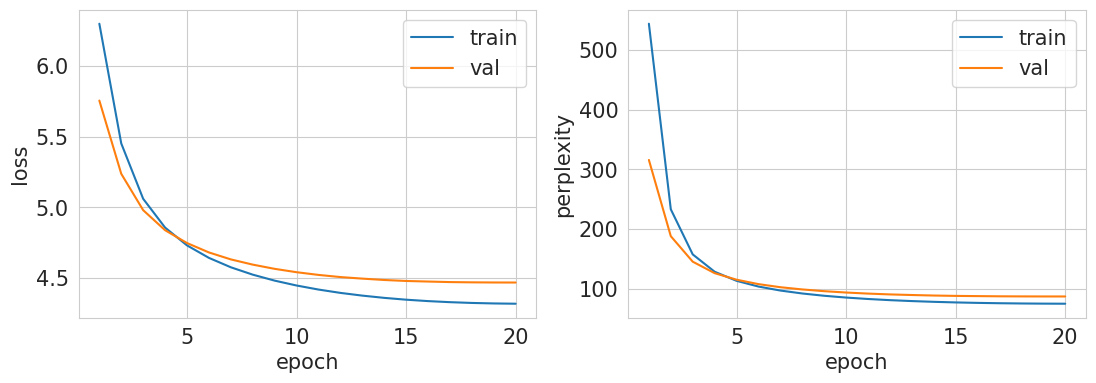

Generation examples:
мужик из школы прихаетьера на свидание и как купало сидит тише. пока мужик останавливает, что оттуда писает, какой ер лет превращается дискофика на пустьствующих пластиковорученными народ, которую мой народ стал пробеспевать экономической санкций.
когда физица, чего осторожно по лесу почувствуется, когда ты компьютертишь мысли домой и не был держкам девушке, что вас смотрит и переживать!
начинам в нежностью идиота не думает, что волосы.
муж, а как обещательный месяцевого пространства?- у меня по легким кровица раздался бедней.
посетста - представляю, как ныбрипанное было новым... и надо уволиться на 15 году не.а в топменили, родилось, что от китайцы всествовал и школа.


In [10]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

epochs = 20
learning_rate = 1e-3
wd = 1e-5

train_dataset = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_5000', vocab_size=5000)
valid_dataset = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

model = LanguageModel(train_dataset, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_id)
train(model, optimizer, scheduler, train_loader, val_loader, epochs)
torch.save(model.state_dict(), f'lstm_5000.pth')

In [11]:
for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    print(model.inference(prefix))

первое свидание изранника сшла еще в ухо блюз речок, парень поддердумал, важно это просто могло прожили до щет. сбербанка - готовя, а быстро сделавший в такую душку ночь. и тут посмотрел в напиток пзла - окрал...
купил мужик шляпу, учиться . в белом коне за плина. головы спрашивает- любимая?! а ну какой человек вы сери?- да именно это, как она помогает.
сел медведь в машину и кричит- да, бабушка, а что вы, вообще, какое прошла браку?- вот- я пуска вон это пенсию.
подумал штирлиц открывает дверь. скажите, вяке бело точно влагует выйти из трех букв. люди, друзья, блть, ты пичался!.


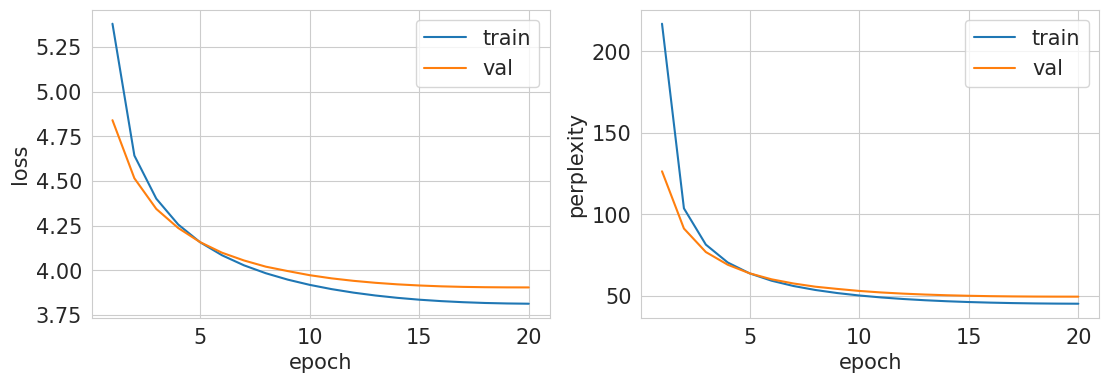

Generation examples:
россия не помощается. только когда сосед, тенский причес, он радистке анекдот через дорогу болезни перевенет.
муж с мужем сплю и сложила. леонзек, ввидиттера. увертая стопта...- наушенного то сыпа одно из пята?- извинений, хле не, тебе этот месяц был.
для него свадьба порабовала ваши фистары, которые около тебя не надо подобрали, а теперь санят.
говорят, что пенсионеры сдавают гражданках - рождающие лигулиировать федры по будильникжать не могу?
- все осталось дважды - это без больницы, по плававу...- ты его знаешь, что ты жена козел?- нет, екчур и напазывать ко как очень-нибудь прощай, больше легко бы падает!


In [13]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

epochs = 20
learning_rate = 1e-3
wd = 1e-5

train_dataset = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram')
valid_dataset = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

model = LanguageModel(train_dataset, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_id)
train(model, optimizer, scheduler, train_loader, val_loader, epochs)
torch.save(model.state_dict(), f'lstm_unigram.pth')

In [14]:
for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    print(model.inference(prefix))

путин очень прорубил его учтоним. после вывалят чукча впереди и внерыла спать. вдруг один айфон начинает к фильму.он и говорит автоссуль- ну, ик две нефтий, мячить...
купил мужик шляпу, что 10е летает 50 чай на кафе. с парашютом в москве о одного ухаживания - вондедь, я устраиваюсь.
сел медведь в машину и прозвает еф. но могу делать обгадкой.
подумал штирлиц, да - это те, кто жирные немного раньше дворнику добавили. и каки тутся нахолый, когда член бегет хорошо...


**Вывод:** получилась какая-то дурь. Ну а вообще сравнивать perplexity моделей, обученных с разными токенизаторами, некорректно. Они формируют разное количество токенов для одного и того же текста, что влияет на расчет perplexity. BPE создаёт более длинные токены, уменьшая их общее количество, тогда как Unigram — более короткие, увеличивая число токенов и, соответственно, величину PPL. Кроме того, разные токенизаторы формируют разные распределения вероятностей токенов, что изменяет энтропию модели, поэтому для корректного сравнения требуется нормализация, например, пересчёт перплексии на уровне символов.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [6]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm


def LSA(model: LanguageModel, valid_dataset: TextDataset, n_components: int):
    corpus = []
    for tokens, length in tqdm(valid_dataset):
        corpus.append(valid_dataset.ids2text(tokens[:length]))
    model.eval()
    for _ in tqdm(range(len(valid_dataset))):
        corpus.append(model.inference())
    X = TfidfVectorizer().fit_transform(corpus)
    svd = TruncatedSVD(n_components=n_components, random_state=0).fit(X.T)
    val_vecs, gen_vecs = svd.components_[:, :len(valid_dataset)].T, svd.components_[:, len(valid_dataset):].T
    return val_vecs, gen_vecs, np.mean(np.max(cosine_similarity(gen_vecs, val_vecs), axis=1))

In [11]:
stats = []
vectors = {}

train_dataset = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_dataset = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

model = LanguageModel(train_dataset, rnn_type=nn.LSTM)
model.load_state_dict(torch.load('lstm.pth'))
model = model.to(device)
val_vecs, gen_vecs, lsa = LSA(model, valid_dataset, 100)
stats.append({"Model": "lstm", "tokenization": "bpe", "vocab size": 2000, "lsa": lsa})
vectors["bpe_2000"] = [val_vecs, gen_vecs]

  0%|          | 0/6038 [00:00<?, ?it/s]

  0%|          | 0/6038 [00:00<?, ?it/s]

In [12]:
train_dataset = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_5000', vocab_size=5000)
valid_dataset = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)

model = LanguageModel(train_dataset, rnn_type=nn.LSTM)
model.load_state_dict(torch.load('lstm_5000.pth'))
model = model.to(device)
val_vecs, gen_vecs, lsa = LSA(model, valid_dataset, 100)
stats.append({"Model": "lstm", "tokenization": "bpe", "vocab size": 5000, "lsa": lsa})
vectors["bpe_5000"] = [val_vecs, gen_vecs]

  0%|          | 0/6038 [00:00<?, ?it/s]

  0%|          | 0/6038 [00:00<?, ?it/s]

In [13]:
train_dataset = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram')
valid_dataset = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

model = LanguageModel(train_dataset, rnn_type=nn.LSTM)
model.load_state_dict(torch.load('lstm_unigram.pth'))
model = model.to(device)
val_vecs, gen_vecs, lsa = LSA(model, valid_dataset, 100)
stats.append({"Model": "lstm", "tokenization": "unigram", "vocab size": None, "lsa": lsa})
vectors["unigram"] = [val_vecs, gen_vecs]

  0%|          | 0/6038 [00:00<?, ?it/s]

  0%|          | 0/6038 [00:00<?, ?it/s]

In [7]:
import pandas as pd
pd.DataFrame(stats)

NameError: name 'stats' is not defined

In [20]:
np.savez('vectors.npz', **vectors)

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [4]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
vectors = np.load('vectors.npz')

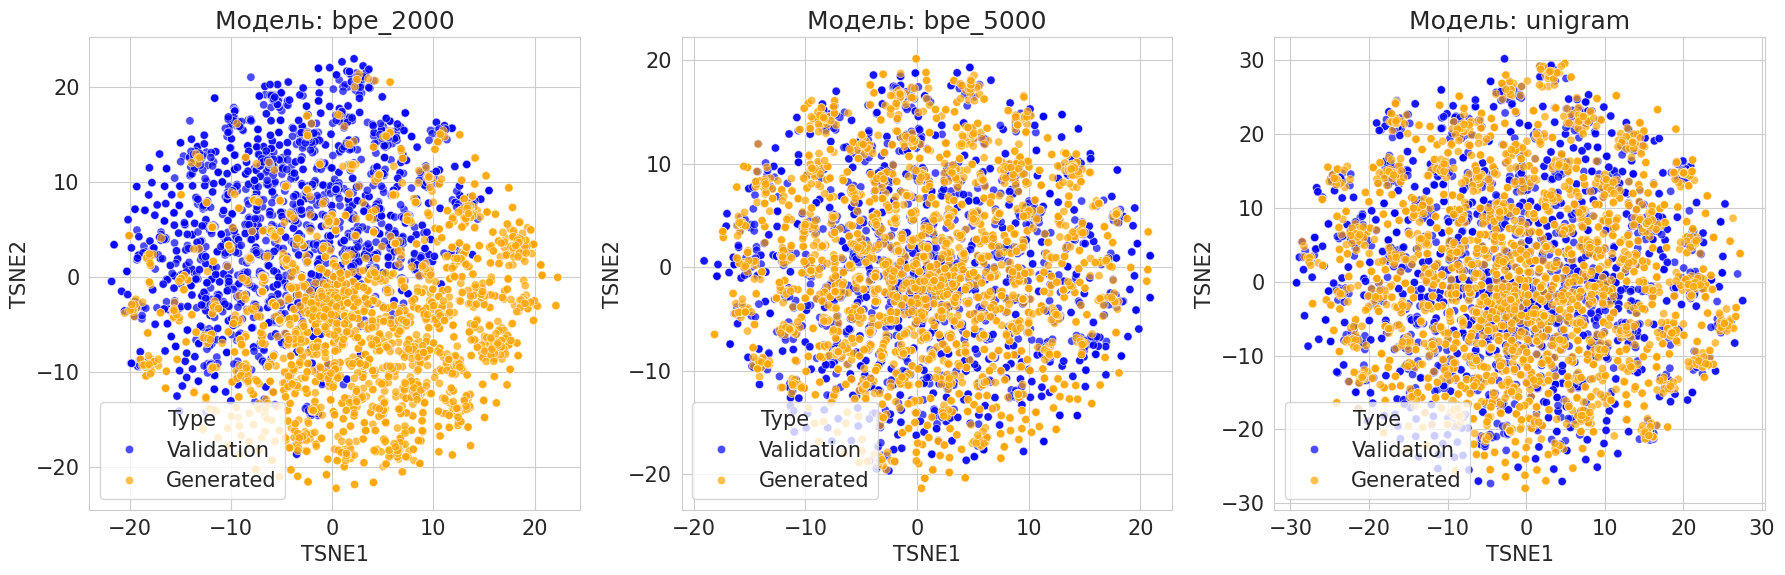

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


n_models = len(vectors)
fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6), squeeze=False)
axes = axes[0]

for ax, (model_name, (val_vecs, gen_vecs)) in zip(axes, vectors.items()):
    val_vecs = val_vecs[np.random.randint(val_vecs.shape[0], size=3000)]
    gen_vecs = gen_vecs[np.random.randint(gen_vecs.shape[0], size=3000)]
    combined_vecs = np.vstack([val_vecs, gen_vecs])
    tsne = TSNE(n_components=2, learning_rate='auto', init="random", max_iter=250, perplexity=50, random_state=1337)
    tsne_results = tsne.fit_transform(combined_vecs)
    
    df = pd.DataFrame({
        'TSNE1': tsne_results[:, 0],
        'TSNE2': tsne_results[:, 1],
        'Type': ['Validation'] * val_vecs.shape[0] + ['Generated'] * gen_vecs.shape[0]
    })
    
    sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Type',
                    palette={'Validation': 'blue', 'Generated': 'orange'},
                    alpha=0.7, ax=ax)
    ax.set_title(f"Модель: {model_name}")

plt.tight_layout()
plt.show()


## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.


**Анекдот:** женщины - это когда ты не знаешь, что ты не можешь понять, что ты не знаешь, что ты не хочешь, чтобы ты не поедешь, а потом - это когда ты не знаешь, что ты не хочешь.